In [ ]:
# 한국어 폰트를 설치합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 런타임 -> 런타임 다시 시작을 실행해주세요

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
!pip install transformers==4.18.0
!pip install datasets==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


이번 실습에서는 Semi Supervised Learning 방법론 중 Holistic Method를 다뤄보겠습니다.  
Holistic Method는 이전에 다뤘던 다양한 Semi-Supervised Learning 방법론의 요소들을 한번에 사용하고자 합니다.  
Self Training - 레이블이 없는 데이터에 대해 Pseudo Labeling  
UDA - 레이블이 없는 데이터에 대한 Augmentation을 이용한 Consistency Regularization

특히 FlexMatch를 중심으로 다루면서, FixMatch와 차이점을 살펴보도록 하겠습니다. 

# 0. Data 불러오기

## 0-1. Data 다운로드 및 예시
온라인 상에 공개되어 있는 데이터를 쉽게 다운받을 수 있도록 도와주는 HuggingFace 사의 Datasets 라이브러리를 이용하여 데이터를 다운로드 받습니다. 이전과 동일하게 dog-food 데이터셋을 이용하도록 하겠습니다.
(https://huggingface.co/datasets/sasha/dog-food)

In [ ]:
import torch
import torch.utils.checkpoint
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch import nn

from transformers import AutoFeatureExtractor, AutoModel, AutoConfig
from torchvision.transforms import Compose, ToTensor, RandomResizedCrop
from datasets import load_dataset


from matplotlib import pyplot as plt
import PIL
from sklearn.metrics import f1_score, accuracy_score
from tqdm.auto import tqdm

import numpy as np
import random
import gc
import os

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

# 시드 고정
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
## 데이터 다운로드 시 1분 이내의 시간이 소요됩니다.
dataset = load_dataset("sasha/dog-food")

## 해당 데이터셋은 Train/Test로 구성되어 있습니다. 이를 우선 분리하겠습니다.
train_dataset = list(dataset["train"])
test_dataset = list(dataset["test"])

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/sasha___parquet/sasha--dog-food-ec42a61d5519cc88/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Text(0.5, 1.0, '머핀 이미지')

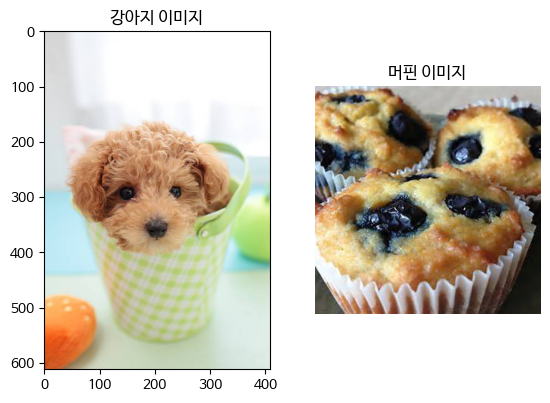

In [ ]:
## 실제 강아지와 음식 사진 예시입니다.
### 강아지 사진은 푸들이 주를 이루고, 음식 사진은 머핀과 치킨이 주를 이루게 됩니다.
plt.subplot(1,2,1)
plt.imshow(train_dataset[3]['image'])
plt.title("강아지 이미지")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(train_dataset[-2]['image'])
plt.axis('off')
plt.title("머핀 이미지")


## 1. Augmentation
UDA를 비롯한 다양한 Semi-Supervised Learning 방법론은 다양한 데이터 증강 기법을 활용합니다.
데이터 증강은 원본 이미지에 평행 이동, 수직이동, 색 반전, 왜곡 등 다양한 변화를 주는 것을 의미합니다.

우선 어떠한 Augmentation 기법이 있는지 살펴보도록 하겠습니다.
- AutoContrast : 이미지의 대비를 최대화합니다.
- Brightness : 이미지의 밝기를 조정합니다.
- Color : 이미지의 색을 조정합니다.
- Contrast : 이미지의 대비를 일정 수준 내에서 조정합니다.
- Equalize : 이미지의 색 분포를 비교적 균등하게 조정합니다.
- Posterize : 이미지의 색 정보를 일부 제거합니다.
- Rotate : 이미지를 회전합니다.
- Shear_x : 이미지를 수평선 방향으로 기울입니다.
- Shear_y : 이미지를 수직선 방향으로 기울입니다.
- Solarize : 이미지의 색을 반전시킵니다.
- Translate_X : 이미지를 평행이동 시킵니다.
- Translate_Y : 이미지를 수직이동 시킵니다.

위 기법들은 기존 UDA 논문의 구현체를 그대로 활용할 수 있습니다.
아래 코드는 UDA 논문의 Augmentation 코드를 가지고 왔습니다. (https://github.com/kekmodel/UDA-pytorch/blob/main/dataset/randaugment.py)

In [ ]:
import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image
from audioop import bias


PARAMETER_MAX = 10
RESAMPLE_MODE = PIL.Image.BILINEAR


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, **kwarg):
    if v == 0:
        return img
    v = _float_parameter(v, max_v)
    v = int(v * min(img.size))
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def CutoutConst(img, v, max_v, **kwarg):
    v = _int_parameter(v, max_v)
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias, **kwarg):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0), RESAMPLE_MODE)


def ShearY(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0), RESAMPLE_MODE)


def Solarize(img, v, max_v, **kwarg):
    v = _int_parameter(v, max_v)
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, threshold=128, **kwarg):
    v = _int_parameter(v, max_v)
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0), RESAMPLE_MODE)


def TranslateY(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v), RESAMPLE_MODE)


def TranslateXConst(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0), RESAMPLE_MODE)


def TranslateYConst(img, v, max_v, **kwarg):
    v = _float_parameter(v, max_v)
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v), RESAMPLE_MODE)


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def rand_augment_pool():
    augs = [(AutoContrast, None, None),
            (Brightness, 1.8, 0.1),
            (Color, 1.8, 0.1),
            (Contrast, 1.8, 0.1),
            (CutoutConst, 40, None),
            (Equalize, None, None),
            (Invert, None, None),
            (Posterize, 4, 0),
            (Rotate, 30, None),
            (Sharpness, 1.8, 0.1),
            (ShearX, 0.3, None),
            (ShearY, 0.3, None),
            (Solarize, 256, None),
            (TranslateXConst, 100, None),
            (TranslateYConst, 100, None),
            ]
    return augs


class RandAugment(object):
    def __init__(self, n, m, resample_mode=PIL.Image.BILINEAR):
        assert n >= 1
        assert m >= 1
        global RESAMPLE_MODE
        RESAMPLE_MODE = resample_mode
        self.n = n
        self.m = m
        self.augment_pool = rand_augment_pool()

    def __call__(self, img, augmentation = None):
        ops = random.choices(self.augment_pool, k=self.n)

        if augmentation is not None:
            op, max_v, bias = augmentation
            return op(img, v=self.m, max_v=max_v, bias=bias)

        for op, max_v, bias in ops:
            prob = np.random.uniform(0.2, 0.8)
            if random.random() + prob >= 1:
                img = op(img, v=self.m, max_v=max_v, bias=bias)
        return img


## 1-1. Augmentation 결과물
각 Augmentation 기법을 적용하면 원본 이미지가 어떻게 변화하는지 살펴보도록 하겠습니다.
아래에서 볼 수 있듯이 Augmentation 기법들은 원본 이미지의 밝기, 대조, 각도, 위치 등을 변형하여 본래 이미지와 다소 다른 이미지를 만들고 있습니다.

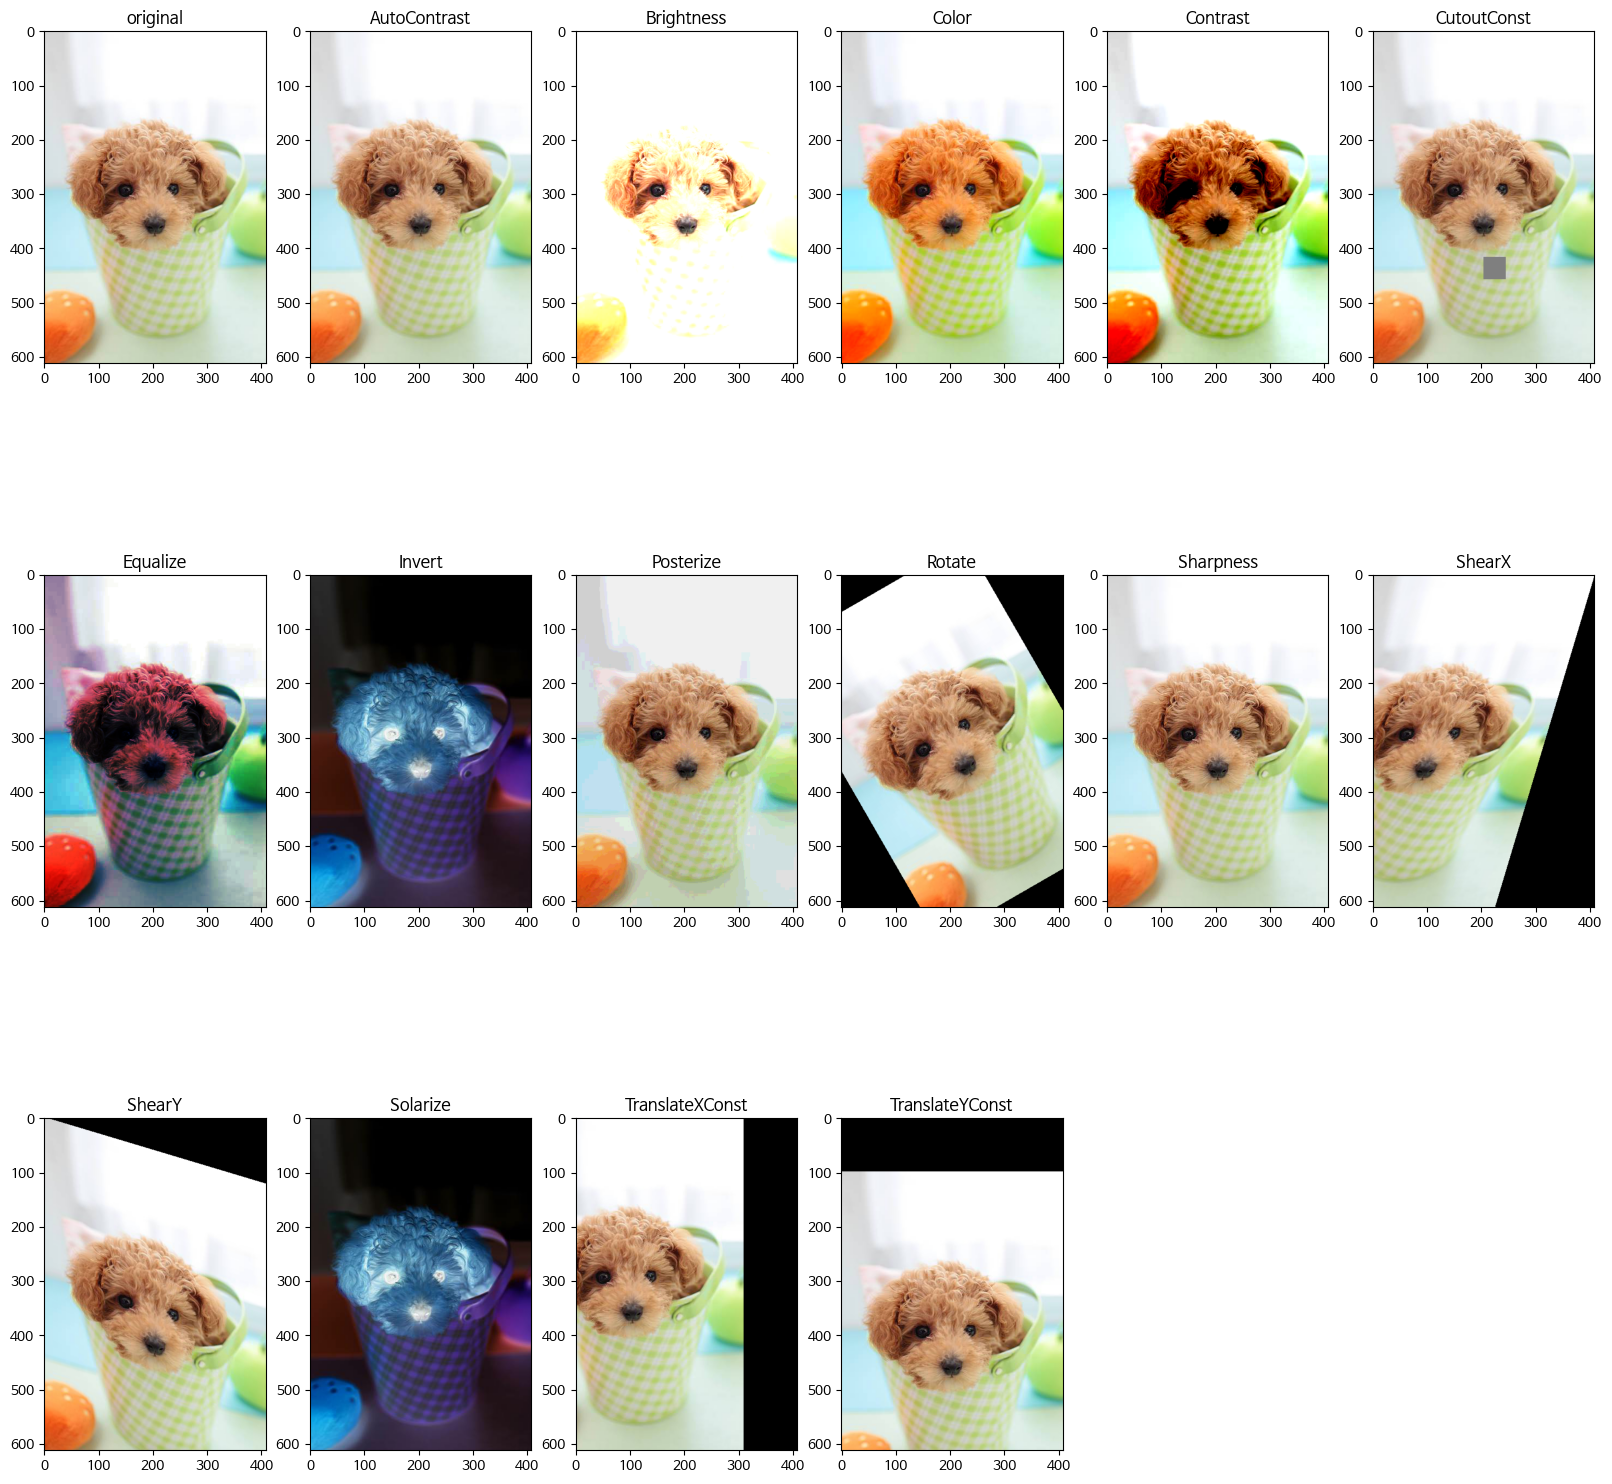

In [ ]:
# visualzie original and each augmentation images

img = train_dataset[3]['image']
plt.figure(figsize=(20, 20))
plt.subplot(3, 6, 1)
plt.imshow(img)
plt.axis('off')
plt.title('original')

for i, (op, max_v, bias) in enumerate(rand_augment_pool()):
    plt.subplot(3, 6, i+2)
    plt.imshow(op(img, v=10, max_v=max_v, bias=bias))
    plt.title(op.__name__)
    plt.axis('off')

### 1-3. Random Augmentation 적용 예시
하지만 실제 UDA 및 FixMatch 등의 논문에서는 복수의 augmentation을 Random하게 선택하여 적용하고 있습니다.
이는 위 구현체 코드에서 RandAugment 클래스를 통해 구현되어 있습니다. 아래 시각화를 통해 살펴보겠습니다.
특히 FixMatch에서는 Strong Augmentation으로 Random Augmentation을 사용하고 있습니다.

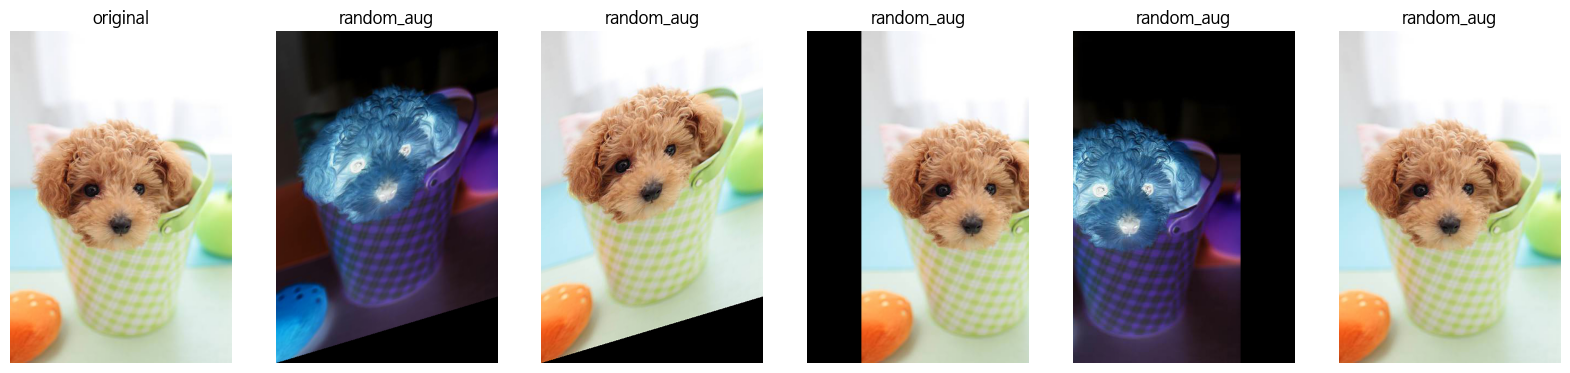

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title('original')
plt.axis('off')

random_aug = RandAugment(n = 3, m = 10)
for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(random_aug(img))
    plt.title('random_aug')
    plt.axis('off')

### 1-4. Weak Augmentation(Flip and Shift)
FixMatch에서 사용하는 Weak Augmentation은 flip(이미지를 상하좌우 뒤집는 것)과 shift(이미지를 이동하는 것)을 사용하고 있습니다.
이는 아래와 같이 pytorch vision 라이브러리를 이용하면 간단하게 구현이 가능합니다.

In [ ]:
# class for randomly flip and shift image
from torchvision.transforms import functional as F
class RandomFlipShift(object):
    def __init__(self, p=0.5, shift_limit=0.0625):
        self.p = p
        self.shift_limit = shift_limit

    def __call__(self, img):
        """ 임의의 확률로 좌우상하 반전 및 이동을 선택하여 실시"""
        p_flip_vertical = random.random()
        p_flip_horizontal = random.random()
        p_shift_x = random.random()
        p_shift_y = random.random()

        if p_flip_vertical < self.p:
            img = F.vflip(img)
        if p_flip_horizontal < self.p:
            img = F.hflip(img)
        if p_shift_x < self.p:
            shift_x = random.random() * self.shift_limit * 2 - self.shift_limit
            img = F.affine(img, angle=0, translate=(shift_x, 0), scale=1, shear=0)
        if p_shift_y < self.p:
            shift_y = random.random() * self.shift_limit * 2 - self.shift_limit
            img = F.affine(img, angle=0, translate=(0, shift_y), scale=1, shear=0)
        return img

위 클래스를 이용하면 아래와 같이 랜덤하게 이미지를 뒤집거나 이동하여 Augmentation을 실시할 수 있습니다.

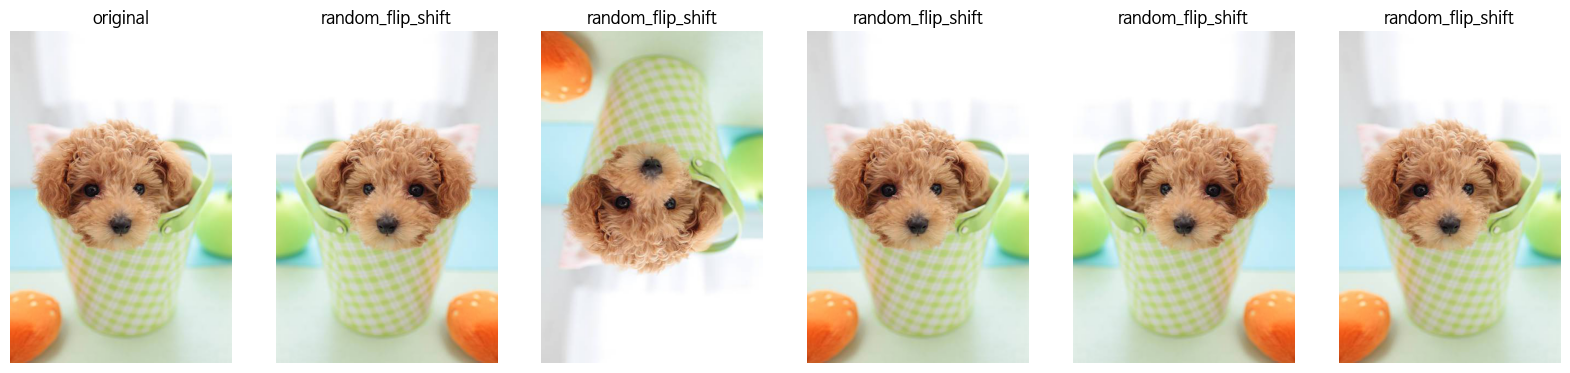

In [ ]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title('original')
plt.axis('off')

random_flip_shift = RandomFlipShift(p=0.5, shift_limit=0.0625)
for i in range(5):
    plt.subplot(1, 6, i+2)
    plt.imshow(random_flip_shift(img))
    plt.title('random_flip_shift')
    plt.axis('off')

### 1-5. 데이터 구축 및 환경 설정
이전 시간과 동일하게 학습 데이터는 아래와 같이 구축될 수 있습니다.

- 소수의 레이블이 있는 데이터
- 다수의 레이블이 없는 데이터

위 구성에 맞추어 학습 데이터를 구축하겠습니다.

In [ ]:
train_labeled_data = []
train_unlabeled_data = []

num_labeled = 8 # 클래스 당 4개씩 레이블이 있는 데이터라고 가정하겠습니다.
num_unlabeled = 512 # 클래스 당 256개씩 레이블이 없는 데이터라고 가정하겠습니다.

num_labeled_0 = 0
num_labeled_1 = 0

num_unlabeled_0 = 0
num_unlabeled_1 = 0

for data_instance in train_dataset :
    img, label = data_instance['image'], data_instance['label']
    if label == 0 and num_labeled_0 < num_labeled//2 : # 강아지 클래스의 데이터를 16개 뽑습니다.
        train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
        num_labeled_0 += 1
    elif label == 1 and num_labeled_1 < num_labeled//2 : # 음식 클래스의 데이터를 16개 뽑습니다.
        train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
        num_labeled_1 += 1
    elif label == 0 and num_unlabeled_0 < num_unlabeled//2 : # 강아지 클래스의 데이터를 256개 뽑습니다.
        train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
        num_unlabeled_0 += 1
    elif label == 1 and num_unlabeled_1 < num_unlabeled//2 : # 음식 클래스의 데이터를 256개 뽑습니다.
        train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
        num_unlabeled_1 += 1

    if (num_labeled_0 == num_labeled//2) and (num_labeled_1 == num_labeled//2) and (num_unlabeled_0 == num_unlabeled//2) and (num_unlabeled_1 == num_unlabeled//2) : # 모든 데이터를 뽑았다면 반복문을 종료합니다.
        break

print("> 학습 데이터셋")
print(f">> 레이블이 있는 데이터셋의 개수 : {len(train_labeled_data)}")
print(f">> 레이블이 없는 데이터셋의 개수 : {len(train_unlabeled_data)}")
print("> 테스트 데이터셋")
print(f">> 테스트 데이터셋의 개수 : {len(test_dataset)}")

> 학습 데이터셋
>> 레이블이 있는 데이터셋의 개수 : 8
>> 레이블이 없는 데이터셋의 개수 : 512
> 테스트 데이터셋
>> 테스트 데이터셋의 개수 : 900


학습 데이터를 활용하기 위한 Dataset 클래스와 모델 클래스를 선언하겠습니다.

In [ ]:
class ImageDataset(torch.utils.data.Dataset) :
    def __init__(self, dataset, weak_augmentation, strong_augmentation = None) :
        self.dataset = dataset # 학습 데이터셋을 해당 클래스 내부에 저장합니다.
        self.weak_augmentation = Compose([ # 레이블이 없는 데이터에 대해 weak augmentation을 적용하기 위해 weak_augmentation을 저장합니다.
            RandomResizedCrop(224),
            weak_augmentation,
            ToTensor()
        ])
        if strong_augmentation is not None :
            self.strong_augmentation = Compose([ # 레이블이 없는 데이터에 대해 strong augmentation을 적용하기 위해 strong_augmentation을 저장합니다.
                RandomResizedCrop(224),
                strong_augmentation,
                ToTensor()
            ])

    def __len__(self) :
        return len(self.dataset)

    def __getitem__(self, idx) : # 해당 메소드는 인덱스를 입력으로 받아 해당 인덱스에 위치한 데이터를 반환합니다.
        image = self.dataset[idx]['image'] # 해당 인덱스에 위치한 이미지를 불러옵니다.
        label = self.dataset[idx]['label'] # 해당 인덱스에 위치한 레이블을 불러옵니다.
        inputs = {} # 반환할 데이터를 저장할 딕셔너리를 선언합니다.

        weak_augmented_img = self.weak_augmentation(image) # weak augmentation을 적용합니다.
        inputs = {'weak_pixel_values' : torch.tensor(weak_augmented_img.data.numpy())} # weak augmentation이 적용된 이미지를 저장합니다.
        if hasattr(self, 'strong_augmentation') : # strong augmentation이 존재한다면
            strong_augmented_img = self.strong_augmentation(image) # strong augmentation을 적용합니다.
            inputs['strong_pixel_values'] = torch.tensor(strong_augmented_img.data.numpy()) # strong augmentation이 적용된 이미지를 저장합니다.

        inputs['labels'] = torch.tensor(label) # Loss 계산을 위해 레이블을 추가합니다.
        inputs['idx'] = torch.tensor(idx) # 향후 분석을 위해 인덱스를 추가합니다.

        return inputs

In [ ]:
class ResNetForImageClassification(nn.Module) :
    def __init__(self, feature_extractor, num_labels=2) :
        super().__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(self.feature_extractor.config.hidden_sizes[-1], num_labels)
        self.softmax = nn.Softmax(dim=-1)
        self.num_labels = num_labels

        self.id2label = {0 : "강아지", 1 : "음식"}

    def forward(self, pixel_values, labels=None) :
        pixel_values = self.feature_extractor(pixel_values)
        logits = self.classifier(pixel_values.pooler_output.squeeze())
        logits = self.softmax(logits,)

        loss = None
        preds = torch.argmax(logits, dim=-1).reshape(-1, 1)
        if labels is not None :
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))


        return {
            "모델의 예측 확률" : logits,
            "loss" : loss,
            "logits" : logits,
            "모델의 정확도" : (sum(preds == labels.reshape(-1, 1))/len(labels)).item() if labels is not None else None,
            "모델의 예측값" : {'text' : [self.id2label[pred.item()] for pred in preds], 'id' : preds}
            }

In [ ]:
# 사용할 모델 역시 이전과 동일한 ResNet50의 구조를 그대로 사용하겠습니다.
config = AutoConfig.from_pretrained("microsoft/resnet-50", output_hidden_states=True)
model = AutoModel.from_config(config)
resnet = ResNetForImageClassification(feature_extractor=model, num_labels=2)

In [ ]:
# 레이블이 있는 데이터셋과 없는 데이터셋을 각각 ImageDataset 클래스로 변환합니다.
## 레이블이 있는 데이터에 대해서는 weak augmentation만 적용합니다.
## 레이블이 없는 데이터에 대해서는 weak augmentation과 strong augmentation을 모두 적용합니다.
weak_augmentation = RandomFlipShift(p=0.5, shift_limit=0.0625)
strong_augmentation = RandAugment(n = 3, m = 10)
train_labeled_dataset = ImageDataset(train_labeled_data, weak_augmentation)
train_unlabeled_dataset = ImageDataset(train_unlabeled_data, weak_augmentation, strong_augmentation)

위에서 선언한 레이블이 있는 데이터와 레이블이 없는 데이터에 대한 batch 단위의 입력값 형태를 살펴보겠습니다.

In [ ]:
for batch in train_labeled_dataset :
    for key, value in batch.items() :
        print(f"{key} : {value.shape}")
    break

weak_pixel_values : torch.Size([3, 224, 224])
labels : torch.Size([])
idx : torch.Size([])


In [ ]:
for batch in train_unlabeled_dataset :
    for key, value in batch.items() :
        print(f"{key} : {value.shape}")
    break

weak_pixel_values : torch.Size([3, 224, 224])
strong_pixel_values : torch.Size([3, 224, 224])
labels : torch.Size([])
idx : torch.Size([])


학습 과정에 대해 시각화하여 살펴보기 위해서 레이블이 없는 데이터에 대한 모델의 예측 클래스와 실제 클래스를 시각화하는 코드를 우선 작성하겠습니다.

In [ ]:
def visualize_unsup_img(dataset, idxs, weak_logits, strong_logits) :
    num_images = 5
    # sample 5 images
    sampled = random.sample(list(range(len(idxs))), num_images)
    idxs = [idxs[i] for i in sampled]
    weak_logits = weak_logits[sampled]
    strong_logits = strong_logits[sampled]

    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 10))
    for i, idx in enumerate(idxs) :
        original_img = dataset[idx]['image']
        label = dataset[idx]['label']
        weak_prob, weak_pred = torch.max(weak_logits[i], dim=-1)
        strong_prob, strong_pred = torch.max(strong_logits[i], dim=-1)

        axes[i].imshow(original_img)
        axes[i].set_title(f"""
레이블 : {label}
Weak Augmentation 예측 : {weak_pred}
Weak Augmentation 예측 확률 : {weak_prob:.4f}
Strong Augmentation 예측 : {strong_pred}
""")
        axes[i].axis('off')

    fig.tight_layout()
    plt.show()


## 2. FlexMatch
FixMatch는 우수한 성능을 보이는 것으로 알려져 있지만, 고정된 threshold를 사용한다는 단점이 존재합니다.  
모델 학습 과정에서 학습하기 어려운 클래스가 존재할 때, 이러한 클래스 별 난이도를 고려한 threhold를 설정하는 것이 중요할 수 있습니다.  
이에 FlexMatch는 클래스 별 난이도를 고려한 threshold 계산 방법을 제안하고 있습니다.  
위에서 다룬 FixMatch 코드를 재활용하되, FlexMatch에 적합한 부분을 수정하면서 구현해보도록 하겠습니다.

### 2-0. 학습 결과물 시각화 함수 선언
해당 함수는 FixMatch 실습에서 사용한 함수와 동일합니다. 

In [ ]:
def visualize_result(num_unsup_over_threshold, sup_loss_list, unsup_loss_list, test_acc_list) :

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.plot(sup_loss_list, label="Supervised Loss", marker = 'o')
    plt.xlabel("Iter")
    plt.ylabel("Sup Loss")
    plt.title("Supervised Loss")


    plt.subplot(1, 4, 2)
    plt.plot(unsup_loss_list, label="Unsupervised Loss", marker = 'o')
    plt.xlabel("Iter")
    plt.ylabel("Unsup Loss")
    plt.title("Unsupervised Loss")

    plt.subplot(1, 4, 3)
    plt.plot(test_acc_list, label="Test Accuracy", marker = "o")
    plt.xlabel('Iter(20)')
    plt.ylabel('Test Acc')
    plt.title("Test Accuracy")

    plt.subplot(1, 4, 4)
    plt.plot(num_unsup_over_threshold, label="# of Over Threshold", marker = "o")
    plt.xlabel("Iteration")
    plt.ylabel("# of Over Threhold")
    plt.title("# of Over Threhold")
    plt.show()

### 2-1. 학습 과정
FlexMatch의 학습 과정은 FixMatch와 동일하지만 아래와 같은 차이점이 존재합니다.
1. 레이블이 없는 데이터에 대한 학습 진행 시 class 별 고정된 threshold를 넘기는 데이터의 수를 산출합니다. 이를 class 별 난이도로 명칭할 수 있습니다.
2. 측정된 클래스 별 난이도를 기반으로, 가장 낮은 난이도를 가지는 클래스가 가장 높은 threshold를 가지도록 클래스 별 threshold를 설정합니다.
3. 2에서 설정된 class 별 threshold를 기준으로 consistency loss를 계산합니다.

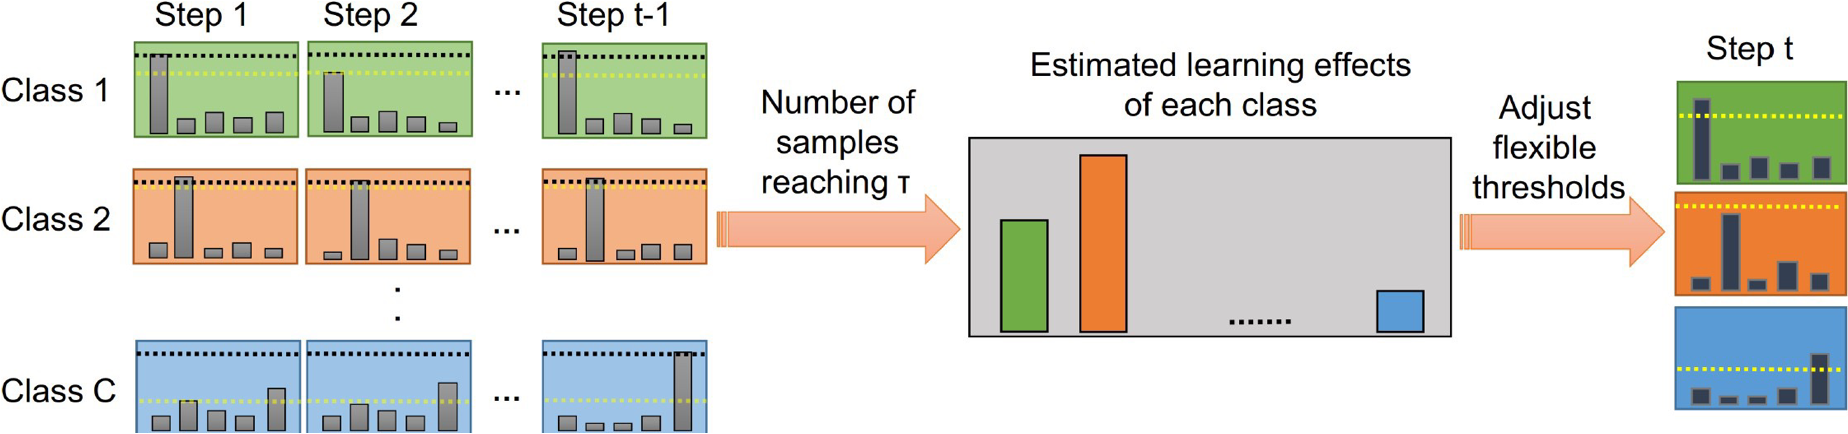

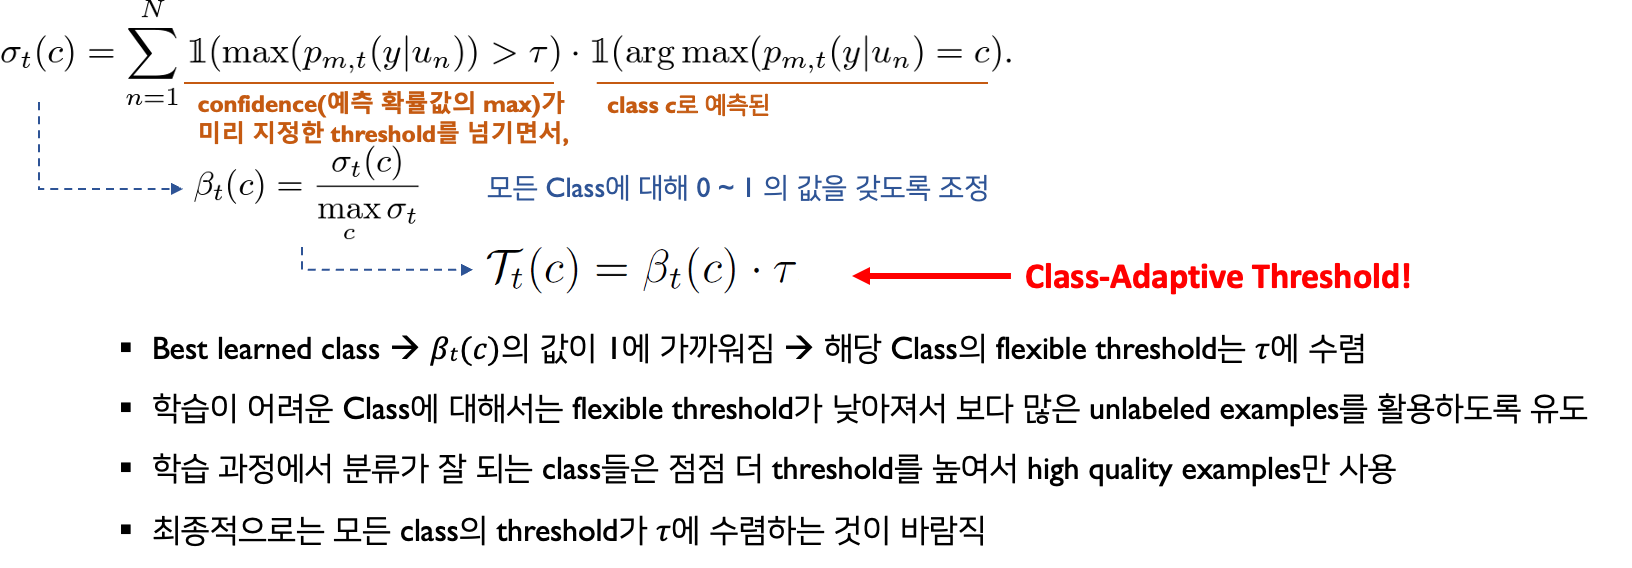

In [ ]:
# 사용할 모델 역시 이전과 동일한 ResNet50의 구조를 그대로 사용하겠습니다.
config = AutoConfig.from_pretrained("microsoft/resnet-50", output_hidden_states=True)
model = AutoModel.from_config(config)
resnet = ResNetForImageClassification(feature_extractor=model, num_labels=2)

batch_size = 8
lr = 1e-4
optimizer = AdamW(resnet.parameters(), lr=lr)
threshold = 0.8

labeled_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
unlabeled_dataloader = DataLoader(train_unlabeled_dataset, batch_size=batch_size*4, shuffle=True) # 레이블이 없는 데이터는 더 큰 배치 사이즈로 학습합니다.

resnet.to(device)
num_unsup_over_threshold_list = []
sup_loss_list = []
unsup_loss_list = []
over_threshold_count = torch.Tensor([0, 0]) # 각 클래스 별로 over_threshold가 몇 번 일어났는지 기록합니다.
threshold_per_class = [threshold, threshold] # 각 클래스 별 난이도가 반영된 threshold를 계산하기 위해 작성된 list 입니다.

for epoch in range(5) :
    for labeled_batch, unlabeled_batch in zip(labeled_dataloader, unlabeled_dataloader) :
        # 0. 각 데이터를 gpu로 이동시킵니다.
        labeled_data = {key : value.to(device) for key, value in labeled_batch.items()}
        unlabeled_data = {key : value.to(device) for key, value in unlabeled_batch.items()}

        # 1. 레이블이 있는 데이터에 대해서는 weak augmentation만 적용하여, 지도학습을 수행합니다.
        sup_loss = resnet(pixel_values=labeled_data['weak_pixel_values'], labels=labeled_data['labels'])['loss']

        # 2. 레이블이 없는 데이터에 대해서는 weak augmentation과 strong augmentation을 모두 적용하여, 비지도학습을 수행합니다.
        ## 이때, 두 Augmentation을 수행하여 모델의 예측값을 우선 산출하게 됩니다.
        weak_output = resnet(pixel_values=unlabeled_data['weak_pixel_values'])
        strong_output = resnet(pixel_values=unlabeled_data['strong_pixel_values'])
        unsup_weak_pred = weak_output['모델의 예측값']['id']
        unsup_strong_pred = strong_output['모델의 예측값']['id']
        unsup_weak_logit = weak_output['logits']
        unsup_strong_logit = strong_output['logits']

        # 3. 모델의 예측값 중에서, 예측 확률이 threshold보다 큰 데이터만을 사용하여, CrossEntropyLoss를 계산합니다.
        ## 3-1. 우선 약한 Augmentation을 적용한 데이터에 대해서, 예측 확률이 높게 부여된 클래스로 레이블을 구축합니다.
        unsup_pseudo_label = torch.argmax(unsup_weak_logit, dim=-1)
        ## 3-2. class 별 threshold를 넘는 데이터의 개수를 계산합니다.
        over_threshold_count[0] = torch.sum((torch.max(unsup_weak_logit, dim=-1).values > threshold) * (unsup_weak_pred == 0))
        over_threshold_count[1] = torch.sum((torch.max(unsup_weak_logit, dim=-1).values > threshold) * (unsup_weak_pred == 1))
        ## 3-3. class 별 threshold를 업데이트합니다.
        max_over_threshold = torch.max(over_threshold_count, dim = -1).values
        class_difficulty = over_threshold_count / max_over_threshold
        threshold_per_class = (threshold/class_difficulty).to(device)

        ## 3-4. 3-3에서 계산된 threshold를 기준으로 unsup_loss를 계산합니다.
        ### 이때 예측 확률이 threshold보다 낮은 데이터에 대해서는, 학습을 진행하지 않는다는 점은 FixMatch와 동일합니다. 구체적으론, 레이블을 -100으로 설정하면, CrossEntropyLoss 계산 시 무시됩니다.
        unsup_pseudo_label[torch.max(unsup_weak_logit, dim=-1).values < threshold_per_class[unsup_weak_pred].squeeze()] = -100
        unsup_loss = CrossEntropyLoss()(unsup_strong_logit, unsup_pseudo_label)

        # 4. 레이블이 없는 데이터 중에서, 예측 확률이 threshold보다 큰 데이터의 개수를 계산합니다. 이는 실험 내용을 살펴보기 위해 산출합니다.
        num_unsup_over_threshold = torch.sum(torch.max(unsup_weak_logit, dim=-1).values > threshold).item()

        num_unsup_over_threshold_list.append(num_unsup_over_threshold)
        sup_loss_list.append(sup_loss.item())
        unsup_loss_list.append(unsup_loss.item())

        # 5. 레이블이 있는 데이터와 없는 데이터로부터 생성된 loss를 이용하여,역전파 후 파라미터를 업데이트합니다.
        loss = sup_loss + unsup_loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # 6. 현재 시점의 Weak Augmentation과 Strong Augmentation을 적용한 데이터에 대한 모델의 예측값과 이미지를 시각화 합니다.
        unsup_weak_prediction = torch.argmax(unsup_weak_logit, dim=-1)
        unsup_strong_prediction = torch.argmax(unsup_strong_logit, dim=-1)
        visualize_unsup_img(train_unlabeled_dataset.dataset, unlabeled_data['idx'], unsup_weak_logit, unsup_strong_logit)

del resnet, unlabeled_data, labeled_data, optimizer
gc.collect()

Output hidden; open in https://colab.research.google.com to view.

### 2-2. 학습과정 함수화
위 학습과정을 자동화할 수 있도록 함수화하고, 간단한 실험을 진행해보겠습니다. 실제로는 get_unsup_loss만 수정하면 됩니다.

In [ ]:
def get_model() :
    config = AutoConfig.from_pretrained("microsoft/resnet-50")
    model = AutoModel.from_config(config)
    resnet = ResNetForImageClassification(model, num_labels=2).to('cuda')
    return resnet

def get_data(num_labeled = 32, num_unlabeled = 512) :
    dataset = load_dataset("sasha/dog-food")

    train_dataset = dataset["train"]
    test_dataset = dataset["test"]

    train_labeled_data = []
    train_unlabeled_data = []

    num_labeled_0 = 0
    num_labeled_1 = 0

    num_unlabeled_0 = 0
    num_unlabeled_1 = 0

    for img, label in zip(train_dataset['image'], train_dataset['label']) :
        if label == 0 and num_labeled_0 < num_labeled//2 : # 강아지 클래스의 데이터를 16개 뽑습니다.
            train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
            num_labeled_0 += 1
        elif label == 1 and num_labeled_1 < num_labeled//2 : # 음식 클래스의 데이터를 16개 뽑습니다.
            train_labeled_data.append({'image' : img, 'label' : label}) # 레이블이 있는 데이터셋에 추가합니다.
            num_labeled_1 += 1
        elif label == 0 and num_unlabeled_0 < num_unlabeled//2 : # 강아지 클래스의 데이터를 256개 뽑습니다.
            train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
            num_unlabeled_0 += 1
        elif label == 1 and num_unlabeled_1 < num_unlabeled//2 : # 음식 클래스의 데이터를 256개 뽑습니다.
            train_unlabeled_data.append({'image' : img, 'label' : label}) # 레이블이 없는 데이터셋에 추가합니다. 레이블이 학습에 활용되지 않지만, 향후 분석 때 사용하기 위해 저장합니다.
            num_unlabeled_1 += 1

        if (num_labeled_0 == num_labeled//2) and (num_labeled_1 == num_labeled//2) and (num_unlabeled_0 == num_unlabeled//2) and (num_unlabeled_1 == num_unlabeled//2) : # 모든 데이터를 뽑았다면 반복문을 종료합니다.
            break

    return train_labeled_data, train_unlabeled_data, test_dataset

def get_dataloader(dataset, batch_size = 4, shuffle = True, is_labeled = True) :
    weak_augmentation = RandomFlipShift(p=0.5, shift_limit=0.0625)
    strong_augmentation = RandAugment(n = 3, m = 10)
    if is_labeled :
        dataset = ImageDataset(dataset, weak_augmentation)
    else :
        dataset = ImageDataset(dataset, weak_augmentation, strong_augmentation)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

def get_unsup_loss(model, unlabeled_batch, threshold) :
    over_threshold_count = torch.Tensor([0, 0])
    weak_output = model(pixel_values=unlabeled_batch['weak_pixel_values'])
    strong_output = model(pixel_values=unlabeled_batch['strong_pixel_values'])
    unsup_weak_pred = weak_output['모델의 예측값']['id']
    unsup_strong_pred = strong_output['모델의 예측값']['id']
    unsup_weak_logit = weak_output['logits']
    unsup_strong_logit = strong_output['logits']

    ## 3-1. 우선 약한 Augmentation을 적용한 데이터에 대해서, 예측 확률이 높게 부여된 클래스로 레이블을 구축합니다.
    unsup_pseudo_label = torch.argmax(unsup_weak_logit, dim=-1)
    ## 3-2. class 별 threshold를 넘는 데이터의 개수를 계산합니다.
    over_threshold_count[0] = torch.sum((torch.max(unsup_weak_logit, dim=-1).values > threshold) * (unsup_weak_pred == 0))
    over_threshold_count[1] = torch.sum((torch.max(unsup_weak_logit, dim=-1).values > threshold) * (unsup_weak_pred == 1))
    ## 3-3. class 별 threshold를 업데이트합니다.
    max_over_threshold = torch.max(over_threshold_count, dim = -1).values
    class_difficulty = over_threshold_count / max_over_threshold
    threshold_per_class = (threshold/class_difficulty).to(device)

    ## 3-4. 3-3에서 계산된 threshold를 기준으로 unsup_loss를 계산합니다.
    ### 이때 예측 확률이 threshold보다 낮은 데이터에 대해서는, 학습을 진행하지 않는다는 점은 FixMatch와 동일합니다. 구체적으론, 레이블을 -100으로 설정하면, CrossEntropyLoss 계산 시 무시됩니다.
    unsup_pseudo_label[torch.max(unsup_weak_logit, dim=-1).values < threshold_per_class[unsup_weak_pred].squeeze()] = -100
    unsup_loss = CrossEntropyLoss()(unsup_strong_logit, unsup_pseudo_label)

    return unsup_loss, over_threshold_count.to('cpu'), unsup_weak_logit.to('cpu'), unsup_strong_logit.to('cpu')

def train(model, optimizer, train_labeled_dataloader, train_unlabeled_dataloader, test_dataloader, threshold = 0.95, beta = 1, num_epoch = 5, log_interval = 1) :
    model.train()

    num_over_threshold_list = []
    sup_loss_list = []
    unsup_loss_list = []
    test_acc_list = []
    iteration = 0
    for epoch_idx in range(num_epoch+1) :
        for labeled_batch, unlabeled_batch in zip(train_labeled_dataloader, train_unlabeled_dataloader) :
            # 0. 각 데이터를 gpu로 이동시킵니다.
            labeled_batch = {key : value.to('cuda') for key, value in labeled_batch.items()}
            unlabeled_batch = {key : value.to('cuda') for key, value in unlabeled_batch.items()}

            # 1. 레이블이 있는 데이터셋에 대한 지도학습 loss를 계산합니다.
            sup_loss = model(pixel_values = labeled_batch['weak_pixel_values'], labels = labeled_batch['labels'])['loss']
            # 2. 레이블이 없는 데이터셋에 대한 비지도학습 loss를 계산합니다.
            unsup_loss, over_threshold_count, unsup_weak_logit, unsup_strong_logit = get_unsup_loss(model, unlabeled_batch, threshold) # 2. 레이블이 없는 데이터셋에 대한 비지도학습 loss를 계산합니다.
            # 3. 지도학습 loss와 비지도학습 loss를 합하여, 총 loss를 계산합니다.
            loss = sup_loss + beta*unsup_loss

            # 4. 총 loss를 이용하여, 모델을 학습시킵니다.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # 5. 학습 과정을 기록합니다.
            if iteration % log_interval == 0 :
                print(f">> Epoch : {epoch_idx+1 :2} | Iteration : {iteration:4} | 지도학습 Loss : {sup_loss.item():.4f} | 비지도학습 Loss : {unsup_loss.item():.4f} | 총 Loss : {loss.item():.4f} | 임계값을 넘은 데이터 수 (0번 클래스, 1번 클래스) : {over_threshold_count.tolist()}")
                visualize_unsup_img(train_unlabeled_dataloader.dataset.dataset, unlabeled_batch['idx'], unsup_weak_logit, unsup_strong_logit)

            num_over_threshold_list.append(over_threshold_count)
            sup_loss_list.append(sup_loss.item())
            unsup_loss_list.append(unsup_loss.item())

            iteration += 1

            if iteration % 20 == 0 :
                test_result = test(model, test_dataloader)
                test_acc_list.append(accuracy_score(test_result[0], test_result[1]))

    return num_over_threshold_list, sup_loss_list, unsup_loss_list, test_acc_list


def test(model, test_dataloader) :
    model.eval()
    pred_list = []
    label_list = []
    with torch.no_grad() :
        for batch in tqdm(test_dataloader, desc="테스트 데이터에 대한 예측 중 : ") :
            batch['weak_pixel_values'] = batch['weak_pixel_values'].to('cuda')
            batch['labels'] = batch['labels'].to('cuda')
            output = model(batch['weak_pixel_values'], batch['labels'])
            pred_list += output['모델의 예측값']['id'].squeeze().tolist()
            label_list += batch['labels'].squeeze().tolist()

    return pred_list, label_list



def train_flexmatch(num_train_epoch, num_labeled, num_unlabeled, threshold = 0.9, beta = 1, log_interval = 1, batch_size = 16) :
    # 0. 모델과 학습 데이터를 불러옵니다.
    train_labeled_data, train_unlabeled_data, test_dataset = get_data(num_labeled, num_unlabeled)
    resnet = get_model()
    optimizer = AdamW(resnet.parameters(), lr=1e-4)

    # 1. 레이블이 있는 데이터셋과 레이블이 없는 데이터셋 각각에 대한 DataLoader를 정의합니다. 이때, 레이블이 없는 데이터셋의 배치 크기는 레이블이 있는 데이터셋의 배치 크기의 4배로 설정합니다. 이는 현실 상황에서 레이블이 없는 데이터가 더 많은 경우가 많기 때문입니다.
    train_labeled_dataloader = get_dataloader(train_labeled_data, shuffle = True, batch_size=batch_size, is_labeled=True)
    train_unlabeled_dataloader = get_dataloader(train_unlabeled_data, shuffle=True, batch_size=batch_size*4, is_labeled=False)
    test_dataloader = get_dataloader(test_dataset, shuffle=False, batch_size=batch_size*2, is_labeled=True)

    print("-"*50)
    print(f">>> 학습 시작")

    # 2. 설정을 바탕으로 모델을 학습시킵니다.
    num_unsup_over_threshold, sup_loss_list, unsup_loss_list, test_acc_list = train(resnet, optimizer, train_labeled_dataloader, train_unlabeled_dataloader, test_dataloader, threshold, beta, num_train_epoch, log_interval)
    print(f">>> 학습 종료")

    # 3. 최종적인 테스트 데이터에 대한 성능을 확인합니다.
    test_result = test(resnet, test_dataloader)
    print(f">>> 최종 테스트 데이터에 대한 성능 : {accuracy_score(test_result[0], test_result[1]):.4f}")

    del resnet
    gc.collect()
    return num_unsup_over_threshold, sup_loss_list, unsup_loss_list, test_acc_list

In [ ]:
gc.collect()
num_unsup_over_threshold, sup_loss_list, unsup_loss_list, test_acc_list = train_flexmatch(num_train_epoch=10, num_labeled=16, num_unlabeled=256, threshold=0.9, beta = 1, log_interval=1, batch_size=4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def visualize_result(num_unsup_over_threshold, sup_loss_list, unsup_loss_list, test_acc_list) :

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 4, 1)
    plt.plot(sup_loss_list, label="Supervised Loss", marker = 'o')
    plt.xlabel("Iter")
    plt.ylabel("Sup Loss")
    plt.title("Supervised Loss")


    plt.subplot(1, 4, 2)
    plt.plot(unsup_loss_list, label="Unsupervised Loss", marker = 'o')
    plt.xlabel("Iter")
    plt.ylabel("Unsup Loss")
    plt.title("Unsupervised Loss")

    plt.subplot(1, 4, 3)
    plt.plot(test_acc_list, label="Test Accuracy", marker = "o")
    plt.xlabel('Iter(20)')
    plt.ylabel('Test Acc')
    plt.title("Test Accuracy")

    plt.subplot(1, 4, 4)
    plt.plot(num_unsup_over_threshold, label="# of Over Threshold", marker = "o")
    plt.xlabel("Iteration")
    plt.ylabel("# of Over Threhold")
    plt.title("# of Over Threhold")
    plt.show()

visualize_result(num_unsup_over_threshold, sup_loss_list, unsup_loss_list, test_acc_list)

### 2-3. 실제 몇가지 실험을 통해 FlexMatch의 학습에 중요한 요소 및 성능 경향을 확인해보겠습니다. 